In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import cv2
from sklearn.metrics import classification_report, confusion_matrix

# Load the final model

In [2]:
def Model_final():
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.25),  

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.25), 

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.25),  

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Dropout(0.25),

        nn.Flatten(),

        nn.Linear(128 * 6 * 6, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, 7)
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model

In [5]:
model = Model_final()
model_name = 'final_model'
filename = f'{model_name}_weights.pth'
model.load_state_dict(torch.load(filename))

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2304, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=7, bias=True)
)


<All keys matched successfully>

Get the video frames from the video file. 
Our sampling framerate is set to 1 per second.

In [37]:
def get_video_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    
    # Check if the video was opened successfully
    if not cap.isOpened():
        print("Error opening video stream or file")
        return []

    # Get frames per second (fps) from the video
    fps = cap.get(cv2.CAP_PROP_FPS)
    frames = []

    plt.ion()  # Enable interactive mode for real-time image display

    frame_count = 0  # Initialize frame counter

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process only the first frame of each second
        if frame_count % int(fps) == 0:
            # Convert the frame from BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Append the frame to the list
            frames.append(frame)

            # Display the frame using matplotlib
            plt.imshow(frame)
            plt.pause(0.001)  # Pause briefly to update the plot
            plt.clf()  # Clear the plot to prepare for the next frame

        frame_count += 1  # Increment frame counter

    # Cleanup
    cap.release()
    plt.ioff()  # Turn off interactive mode
    return frames

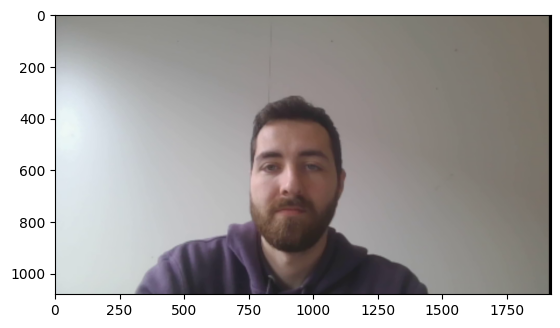

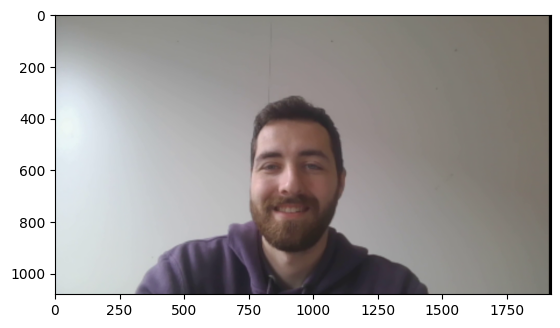

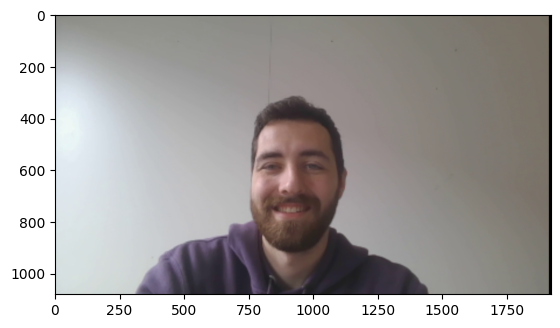

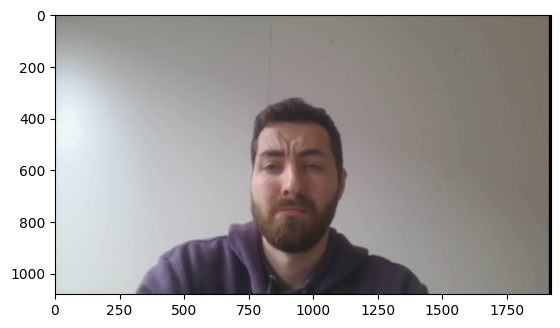

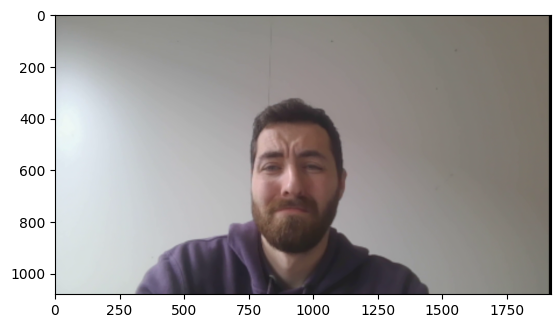

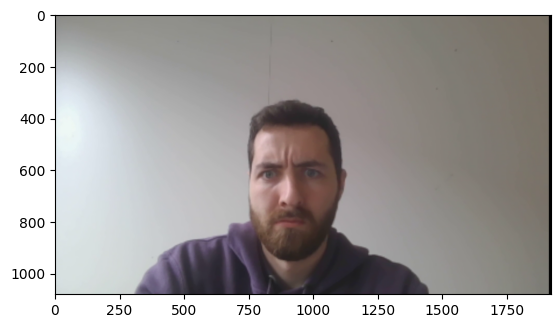

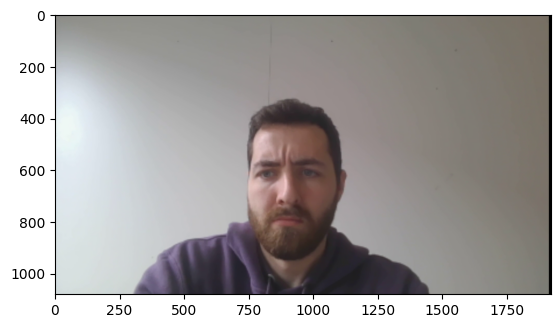

<Figure size 640x480 with 0 Axes>

In [38]:
video_path = '2024-05-24 14-53-08.mp4'
frames_dimitris = get_video_frames(video_path)

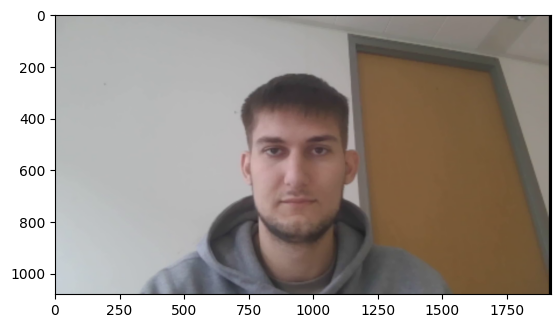

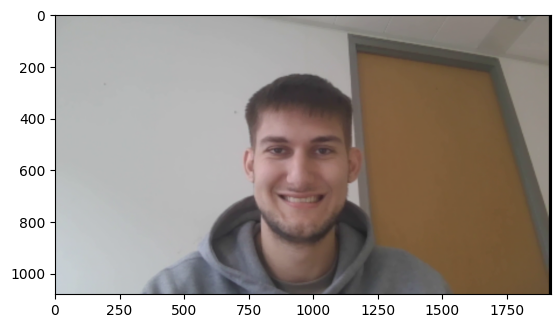

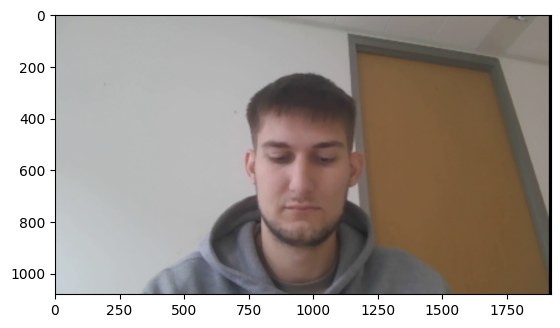

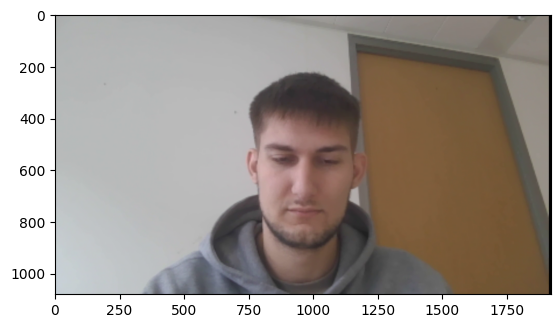

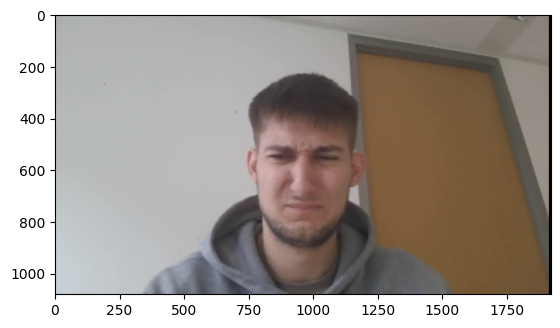

<Figure size 640x480 with 0 Axes>

In [10]:
video_path = '2024-05-24 14-52-52.mp4'
frames_giorgos = get_video_frames(video_path)

Get rectangle that contains the face using the cascade classifier and then create the tensors for that image

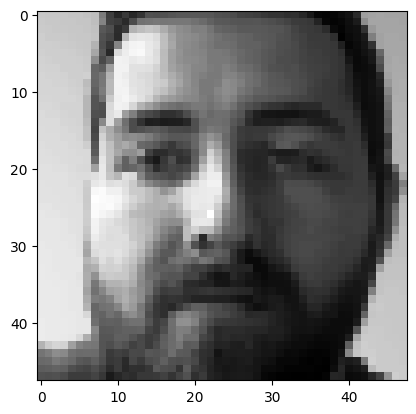

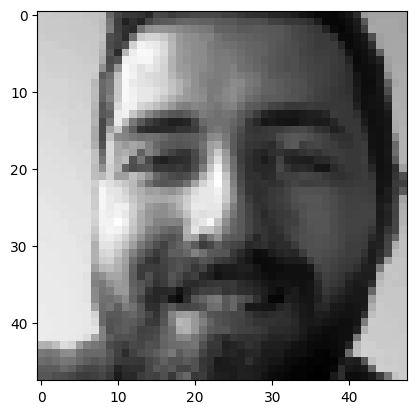

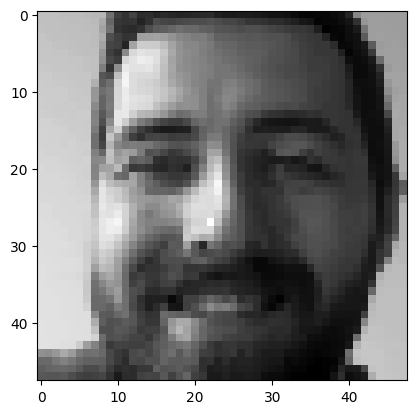

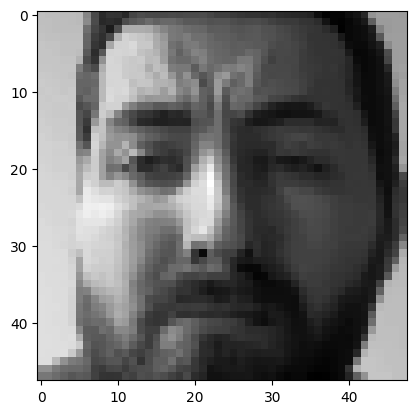

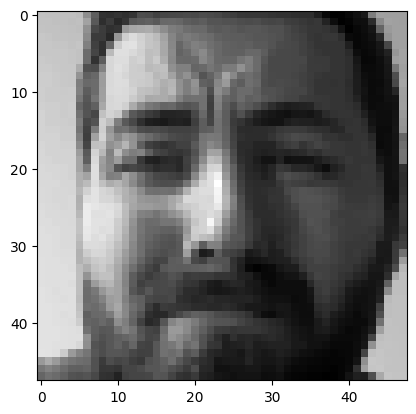

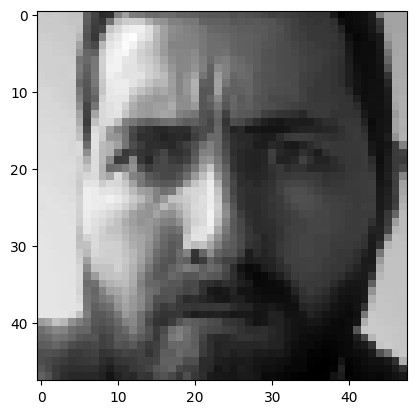

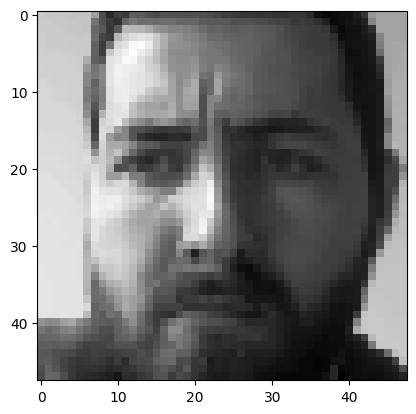

In [39]:
def create_tensors_from_face(frames):
    f_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    extr_images = []
    extr_tensors = []
    for frame in frames:
        image = frame.copy()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = f_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            img = cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)

            extr_img = img[y:y+h,x:x+h]
            extr_final_img = cv2.resize(extr_img, (48, 48))
            extr_final_img_gray = cv2.cvtColor(extr_final_img, cv2.COLOR_BGR2GRAY) 
            extr_images.append(extr_final_img_gray)
            plt.imshow(extr_final_img_gray, cmap='gray')
            plt.show()

            # From the other notebook we found that the values we will normalize with are:
            mean = 0.5077425080522144
            std = 0.25500891562522027

            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[mean], std=[std]) # Normalize based on the training data

            ])  
            tensor = transform(extr_final_img_gray)
            tensor = tensor.unsqueeze(0)
            extr_tensors.append(tensor.cuda())

    return extr_final_img_gray, extr_tensors


In [ ]:
images_dimitris, tensors_dimitris = create_tensors_from_face(frames_dimitris)

In [ ]:
images_giorgos, tensors_giorgos = create_tensors_from_face(frames_giorgos)

In [35]:
def predict(model, test_image):
    model.eval()
    y_pred = model(test_image)
    y_pred_numpy = torch.argmax(y_pred).detach().cpu().numpy()
    return y_pred_numpy 

In [ ]:
emotion_label= {0:'0 (anger)',1:'1 (disgust)',2:'2 (fear)',3:'3 (happiness)',4:'4 (sadness)',5:'5 (surprise)',6:'6 (neutral)'}

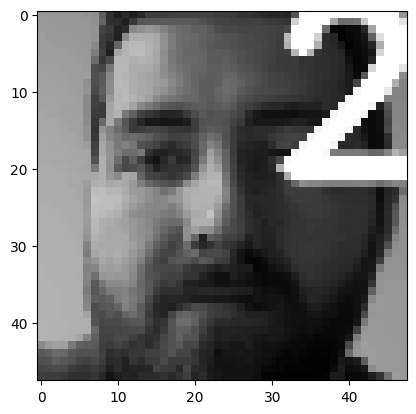

[[-0.58138317 -2.9466634   1.0176764   0.43848613  0.7425427  -0.8693444
   0.23846972]]


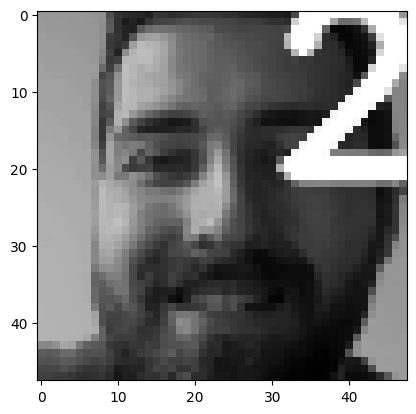

[[-0.922508   -2.4750607   1.1929386  -0.37536076  1.0913486  -0.06856672
  -0.01902969]]


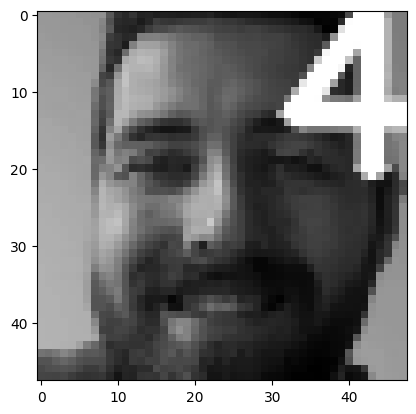

[[-1.1376925  -2.8169212   1.1092515  -0.11766469  1.1656884   0.41270217
  -0.05293445]]


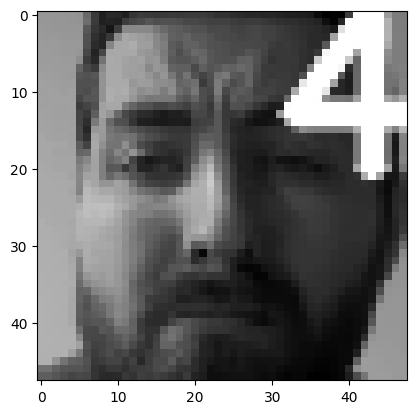

[[-0.6512852  -2.6012206   1.1635869   0.75525     1.5029775  -1.3913922
  -0.46361735]]


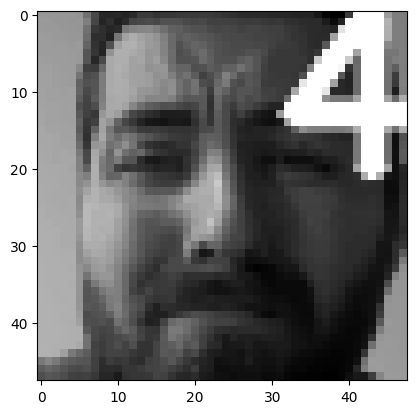

[[-0.90820116 -2.2027478   1.1928391   0.25485703  1.623626   -0.9930877
  -0.37912536]]


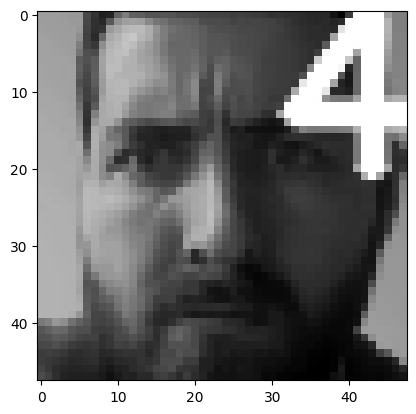

[[ 1.6975759e-02 -2.5373914e+00  9.4425857e-01  5.8279759e-01
   1.0998907e+00 -2.0326140e+00  2.4171472e-03]]


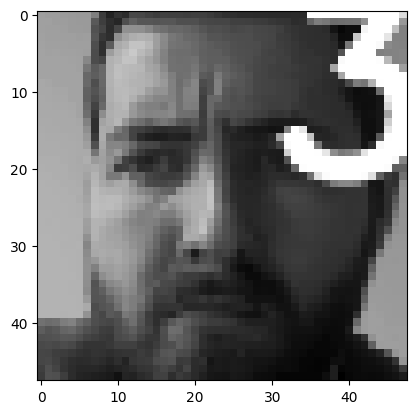

[[-0.17916757 -2.8952467   0.8946739   1.0785084   0.9725204  -1.880347
   0.02978122]]


In [36]:
for image, tensor in zip(images_dimitris, tensors_dimitris):
    pred = predict(model, tensor)
    copy = image.copy()
    copy = cv2.putText(copy, str(emotion_label[int(pred)]), (30,20), cv2.FONT_HERSHEY_SIMPLEX,  
                0.5, (255,0,0), 2, cv2.LINE_AA) 
    
    plt.imshow(image, cmap='gray')
    plt.show()
    print(emotion_label[int(pred)])

In [ ]:
for image, tensor in zip(images_giorgos, tensors_giorgos):
    pred = predict(model, tensor)
    copy = image.copy()
    copy = cv2.putText(copy, str(emotion_label[int(pred)]), (30,20), cv2.FONT_HERSHEY_SIMPLEX,  
                0.5, (255,0,0), 2, cv2.LINE_AA) 
    
    plt.imshow(image, cmap='gray')
    plt.show()
    print(emotion_label[int(pred)])